# Creating a searchable index of the National Jukebox

_Extracting text from audio and indexing it with BigQuery DataFrames_

* Tim Swena (formerly, Swast)
* swast@google.com
* https://vis.social/@timswast on Mastodon

This notebook lives in

* https://github.com/tswast/code-snippets
* at https://github.com/tswast/code-snippets/blob/main/2025/national-jukebox/transcribe_songs.ipynb

To follow along, you'll need a Google Cloud project

* Go to https://cloud.google.com/free to start a free trial.

The National Jukebox is a project of the USA Library of Congress to provide access to thousands of acoustic sound recordings from the very earliest days of the commercial record industry.

* Learn more at https://www.loc.gov/collections/national-jukebox/about-this-collection/

<img src="https://www.loc.gov/static/collections/national-jukebox/images/acoustic-session.jpg" alt="recording 100+ years ago" width="400px" />


To search the National Jukebox, we combine powerful features of BigQuery:

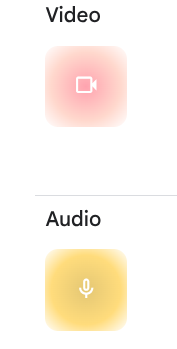

1. Integrations with multi-modal AI models to extract information from unstructured data, in this case audio files.

   https://cloud.google.com/bigquery/docs/multimodal-data-dataframes-tutorial
   
2. Vector search to find similar text using embedding models.

   https://cloud.google.com/bigquery/docs/vector-index-text-search-tutorial

3. BigQuery DataFrames to use Python instead of SQL.

   https://cloud.google.com/bigquery/docs/bigquery-dataframes-introduction

## Getting started with BigQuery DataFrames (bigframes)

Install the bigframes package.

In [ ]:
%pip install --upgrade bigframes google-cloud-automl google-cloud-translate google-ai-generativelanguage tensorflow 

**Important:** restart the kernel by going to "Run -> Restart & clear cell outputs" before continuing.

Configure bigframes to use your GCP project. First, go to "Add-ons -> Google Cloud SDK" and click the "Attach" button. Then,

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [ ]:
import bigframes._config
import bigframes.pandas as bpd

bpd.options.bigquery.location = "US"

# Set to your GCP project ID.
bpd.options.bigquery.project = "swast-scratch"

## Reading data

BigQuery DataFrames can read data from BigQuery, GCS, or even local sources. With `engine="bigquery"`, BigQuery's distributed processing reads the file without it ever having to reach your local Python environment.

In [ ]:
df = bpd.read_json(
    "gs://cloud-samples-data/third-party/usa-loc-national-jukebox/jukebox.jsonl",
    engine="bigquery",
    orient="records",
    lines=True,
)

In [ ]:
# Use `peek()` instead of `head()` to see arbitrary rows rather than the "first" rows.
df.peek()

In [ ]:
df.shape

In [ ]:
# For the purposes of a demo, select only a subset of rows.
df = df.sample(n=250)
df.cache()
df.shape

In [ ]:
# As a side effect of how I extracted the song information from the HTML DOM,
# we ended up with lists in places where we only expect one item.
#
# We can "explode" to flatten these lists.
flattened = df.explode([
    "Recording Repository",
    "Recording Label",
    "Recording Take Number",
    "Recording Date",
    "Recording Matrix Number",
    "Recording Catalog Number",
    "Media Size",
    "Recording Location",
    "Summary",
    "Rights Advisory",
    "Title",
])
flattened.peek()

In [ ]:
flattened.shape

To access unstructured data from BigQuery, create a URI pointing to a file in Google Cloud Storage (GCS). Then, construct a "blob" (also known as an "Object Ref" in BigQuery terms) so that BigQuery can read from GCS.

In [ ]:
flattened = flattened.assign(**{
    "GCS Prefix": "gs://cloud-samples-data/third-party/usa-loc-national-jukebox/",
    "GCS Stub": flattened['URL'].str.extract(r'/(jukebox-[0-9]+)/'),
})
flattened["GCS URI"] = flattened["GCS Prefix"] + flattened["GCS Stub"] + ".mp3"
flattened["GCS Blob"] = flattened["GCS URI"].str.to_blob()

BigQuery (and BigQuery DataFrames) provide access to powerful models and multimodal capabilities. Here, we transcribe audio to text.

In [ ]:
flattened["Transcription"] = flattened["GCS Blob"].blob.audio_transcribe(
    model_name="gemini-2.0-flash-001",
    verbose=True,
)
flattened["Transcription"]

Sometimes the model has transient errors. Check the status column to see if there are errors.

In [ ]:
print(f"Successful rows: {(flattened['Transcription'].struct.field('status') == '').sum()}")
print(f"Failed rows: {(flattened['Transcription'].struct.field('status') != '').sum()}")
flattened.shape

In [ ]:
# Show transcribed lyrics.
flattened["Transcription"].struct.field("content")

In [ ]:
# Find all instrumentatal songs
instrumental = flattened[flattened["Transcription"].struct.field("content") == ""]
print(instrumental.shape)
song = instrumental.peek(1)
song

In [ ]:
import gcsfs
import IPython.display

fs = gcsfs.GCSFileSystem(project='bigframes-dev')
with fs.open(song["GCS URI"].iloc[0]) as song_file:
    song_bytes = song_file.read()

IPython.display.Audio(song_bytes)

## Creating a searchable index

To be able to search by semantics rather than just text, generate embeddings and then create an index to efficiently search these.

See also, this example: https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/generative_ai/bq_dataframes_llm_vector_search.ipynb

In [ ]:
from bigframes.ml.llm import TextEmbeddingGenerator

text_model = TextEmbeddingGenerator(model_name="text-multilingual-embedding-002")

In [ ]:
df_to_index = (
    flattened
    .assign(content=flattened["Transcription"].struct.field("content"))
    [flattened["Transcription"].struct.field("content") != ""]
)
embedding = text_model.predict(df_to_index)
embedding.peek(1)

In [ ]:
# Check the status column to look for errors.
print(f"Successful rows: {(embedding['ml_generate_embedding_status'] == '').sum()}")
print(f"Failed rows: {(embedding['ml_generate_embedding_status'] != '').sum()}")
embedding.shape

We're now ready to save this to a table.

In [ ]:
embedding_table_id = f"{bpd.options.bigquery.project}.kaggle.national_jukebox"
embedding.to_gbq(embedding_table_id, if_exists="replace")

## Searching the database

To search by semantics, we:

1. Turn our search string into an embedding using the same model as our index.
2. Find the closest matches to the search string.

In [ ]:
import bigframes.pandas as bpd

df_written = bpd.read_gbq(embedding_table_id)
df_written.peek(1)

In [ ]:
from bigframes.ml.llm import TextEmbeddingGenerator

search_string = "walking home"

text_model = TextEmbeddingGenerator(model_name="text-multilingual-embedding-002")
search_df = bpd.DataFrame([search_string], columns=['search_string'])
search_embedding = text_model.predict(search_df)
search_embedding

In [ ]:
import bigframes.bigquery as bbq

vector_search_results = bbq.vector_search(
    base_table=f"swast-scratch.scipy2025.national_jukebox",
    column_to_search="ml_generate_embedding_result",
    query=search_embedding,
    distance_type="COSINE",
    query_column_to_search="ml_generate_embedding_result",
    top_k=5,
)

In [ ]:
vector_search_results.dtypes

In [ ]:
results = vector_search_results[["Title", "Summary", "Names", "GCS URI", "Transcription", "distance"]].sort_values("distance").to_pandas()
results

In [ ]:
print(results["Transcription"].struct.field("content").iloc[0])

In [ ]:
import gcsfs
import IPython.display

fs = gcsfs.GCSFileSystem(project='bigframes-dev')
with fs.open(results["GCS URI"].iloc[0]) as song_file:
    song_bytes = song_file.read()

IPython.display.Audio(song_bytes)